In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import glob
import random
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU

In [ ]:
SIZE_X = 256
SIZE_Y = 256
n_classes=7
num_images = 700

In [3]:
image_names = glob.glob('/content/drive/MyDrive/Coding Projects/Water Body Images/256 patches_training/image_1000/*.jpg')
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [
    cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    for image in image_names_subset
]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset

array([[[[[196, 165, 119]],

         [[197, 166, 120]],

         [[194, 163, 117]],

         ...,

         [[211, 177, 129]],

         [[210, 176, 128]],

         [[207, 173, 125]]],


        [[[200, 169, 123]],

         [[201, 170, 124]],

         [[199, 168, 122]],

         ...,

         [[210, 176, 128]],

         [[209, 175, 127]],

         [[211, 177, 129]]],


        [[[200, 169, 122]],

         [[203, 172, 125]],

         [[204, 172, 125]],

         ...,

         [[208, 174, 126]],

         [[210, 176, 128]],

         [[213, 179, 131]]],


        ...,


        [[[ 87,  82,  62]],

         [[ 90,  85,  65]],

         [[ 86,  81,  61]],

         ...,

         [[ 60,  78,  52]],

         [[ 59,  77,  51]],

         [[ 58,  76,  50]]],


        [[[ 87,  82,  62]],

         [[ 89,  84,  64]],

         [[ 86,  81,  61]],

         ...,

         [[ 60,  80,  53]],

         [[ 59,  77,  51]],

         [[ 57,  75,  49]]],


        [[[ 91,  86,  66]],

 

In [4]:
mask_names = glob.glob('/content/drive/MyDrive/Coding Projects/Water Body Images/256 patches_training/mask_1000/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225]],

       [[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105]],

       [[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105]],

       ...,

       [[105, 105, 105, ..., 178, 178, 178],
        [105, 105, 105, ..., 178, 178, 178],
        [105, 105, 105, ..., 178, 178, 178

In [5]:
print("Image data shape :", image_dataset.shape)
print("Mask data shape :", mask_dataset.shape)
print("Maximum pixel value in images :", image_dataset.max())
print("Labels in masks :", np.unique(mask_dataset))
print("Number of labels :", len(np.unique(mask_dataset)))

Image data shape : (700, 256, 256, 1, 3)
Mask data shape : (700, 256, 256)
Maximum pixel value in images : 255
Labels in masks : [  0  29 105 149 178 225 255]
Number of labels : 7


In [ ]:
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [7]:
label_to_land_type = {
    0: "unknown",
    1: "water",
    2: "rangeland",
    3: "forest_land",
    4: "urban_land",
    5: "agriculture_land",
    6: "barren_land"
}

In [8]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(700, 256, 256, 1)


In [9]:
image_dataset = image_dataset / 255.
image_dataset

array([[[[[0.76862745, 0.64705882, 0.46666667]],

         [[0.77254902, 0.65098039, 0.47058824]],

         [[0.76078431, 0.63921569, 0.45882353]],

         ...,

         [[0.82745098, 0.69411765, 0.50588235]],

         [[0.82352941, 0.69019608, 0.50196078]],

         [[0.81176471, 0.67843137, 0.49019608]]],


        [[[0.78431373, 0.6627451 , 0.48235294]],

         [[0.78823529, 0.66666667, 0.48627451]],

         [[0.78039216, 0.65882353, 0.47843137]],

         ...,

         [[0.82352941, 0.69019608, 0.50196078]],

         [[0.81960784, 0.68627451, 0.49803922]],

         [[0.82745098, 0.69411765, 0.50588235]]],


        [[[0.78431373, 0.6627451 , 0.47843137]],

         [[0.79607843, 0.6745098 , 0.49019608]],

         [[0.8       , 0.6745098 , 0.49019608]],

         ...,

         [[0.81568627, 0.68235294, 0.49411765]],

         [[0.82352941, 0.69019608, 0.50196078]],

         [[0.83529412, 0.70196078, 0.51372549]]],


        ...,


        [[[0.34117647, 0.32156863,

In [10]:
image_dataset = image_dataset.reshape((image_dataset.shape[0], image_dataset.shape[1], image_dataset.shape[2], image_dataset.shape[4]))
print("Fixed image_dataset shape:", image_dataset.shape)

Fixed image_dataset shape: (700, 256, 256, 3)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [12]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape)

(560, 256, 256, 7)


In [13]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('Input Shape :', input_shape)

Input Shape : (256, 256, 3)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train shape: (560, 256, 256, 3)
y_train_cat shape: (560, 256, 256, 7)
X_test shape: (140, 256, 256, 3)
y_test_cat shape: (140, 256, 256, 7)


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        ce_loss = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * ce_loss, axis=-1)
    return loss

def combined_loss(y_true, y_pred):
    loss_ce = CategoricalCrossentropy()(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    loss_focal = focal_loss()(y_true, y_pred)
    return 0.4 * loss_ce + 0.4 * loss_dice + 0.2 * loss_focal

In [16]:
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Accuracy over Epoch', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Loss over Epoch', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('Loss', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')

    plt.suptitle(f'{title}', fontweight='bold', fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [ ]:
def visualize_predictions(model, num_images=10):
    for i in range(num_images):
        test_img_number = random.randint(0, len(X_test) - 1)
        test_img = X_test[test_img_number]
        ground_truth = y_test[test_img_number]

        test_img_input = np.expand_dims(test_img, 0)

        prediction = model.predict(test_img_input)

        predicted_img = np.argmax(prediction, axis=3)[0, :, :]

        ground_truth_img = ground_truth[:, :, 0]

        plt.figure(figsize=(12, 8))

        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_img)

        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(ground_truth_img)

        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(predicted_img)

        plt.show()

In [ ]:
def evaluate_model_performance(model, n_classes=7):

    IOU_keras = MeanIoU(num_classes=n_classes)

    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=-1)

    IOU_keras.update_state(y_test[:, :, :, 0], y_pred_class)
    print("Mean IoU :", IOU_keras.result().numpy())

    y_true = y_test[:, :, :, 0].flatten()
    y_pred = y_pred_class.flatten()

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    class_labels = [label_to_land_type[i] for i in range(n_classes)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix', weight='bold')
    plt.xlabel('Predicted Labels', weight='bold')
    plt.ylabel('True Labels', weight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.show()

    IoU_per_class = []
    for i in range(n_classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        IoU = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
        IoU_per_class.append(IoU)

    for i in range(n_classes):
        print(f"IoU for Class '{label_to_land_type[i]}' : {IoU_per_class[i]:.4f}")

U-Net

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(input)
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3,3), strides=(2,2), padding="same")(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = "sigmoid" if n_classes == 1 else "softmax"
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

model_UNet = build_unet(input_shape, n_classes)
model_UNet.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['accuracy'])
model_UNet.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      4,719,104 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 34,513,735 (131.66 MB)

 Trainable params: 34,513,735 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_UNet = model_UNet.fit(X_train, y_train_cat,
                              batch_size = 4,
                              verbose=1,
                              epochs=75,
                              validation_data=(X_test, y_test_cat),
                              shuffle=True)

Epoch 1/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 419ms/step - accuracy: 0.3645 - loss: 1.0793 - val_accuracy: 0.3316 - val_loss: 1.0408
Epoch 2/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 84s 278ms/step - accuracy: 0.3755 - loss: 0.9948 - val_accuracy: 0.3364 - val_loss: 1.0141
Epoch 3/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.3830 - loss: 0.9923 - val_accuracy: 0.2437 - val_loss: 1.0439
Epoch 4/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.3518 - loss: 1.4860 - val_accuracy: 0.3316 - val_loss: 1.0276
Epoch 5/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.3586 - loss: 0.9935 - val_accuracy: 0.3316 - val_loss: 1.0512
Epoch 6/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.3884 - loss: 0.9849 - val_accuracy: 0.3468 - val_loss: 0.9938
Epoch 7/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.3701 - loss: 0.9786 - val_accuracy: 0.3423 - val_loss: 0.9948
Epoch 8/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.3428 - loss: 

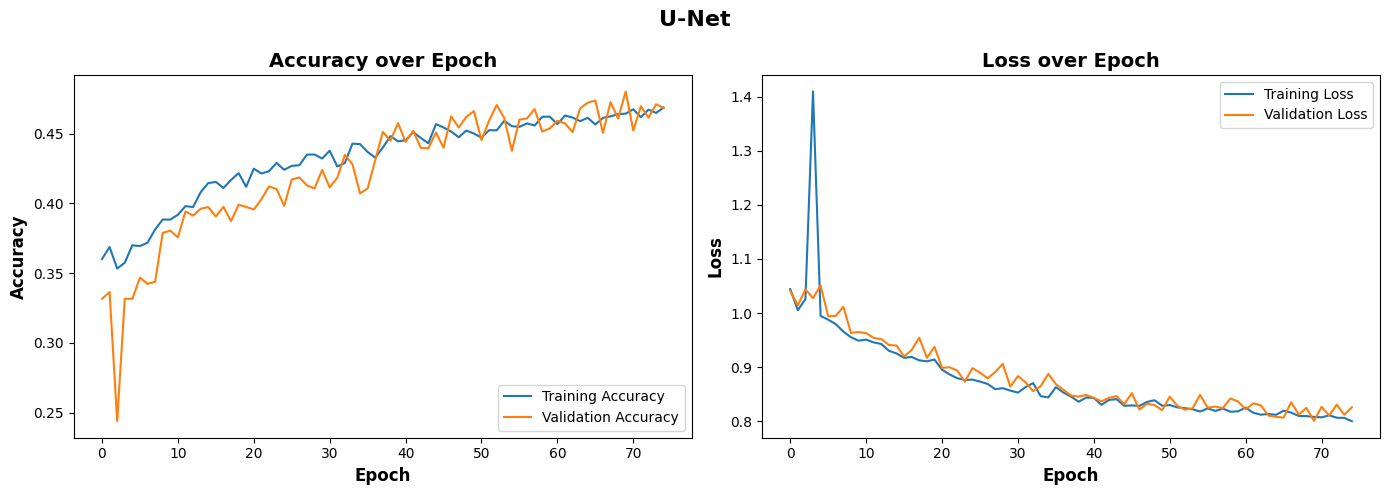

In [21]:
plot_training_history(history_UNet, 'U-Net')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


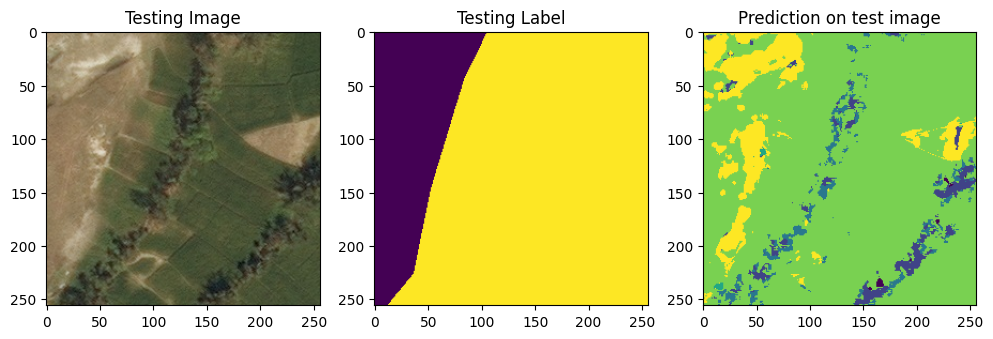

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


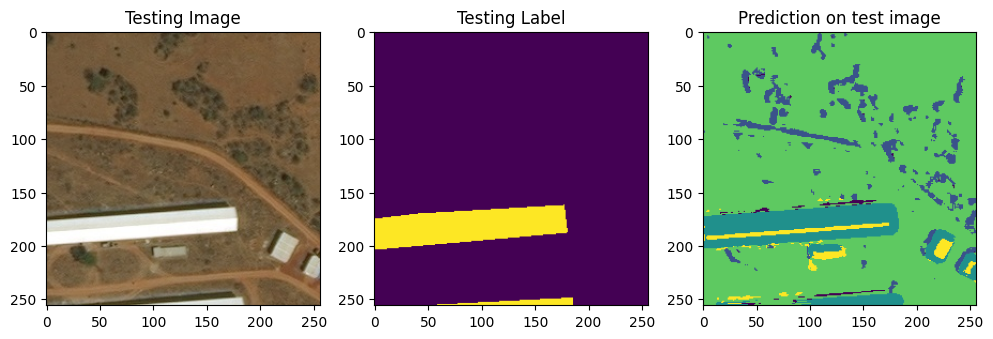

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


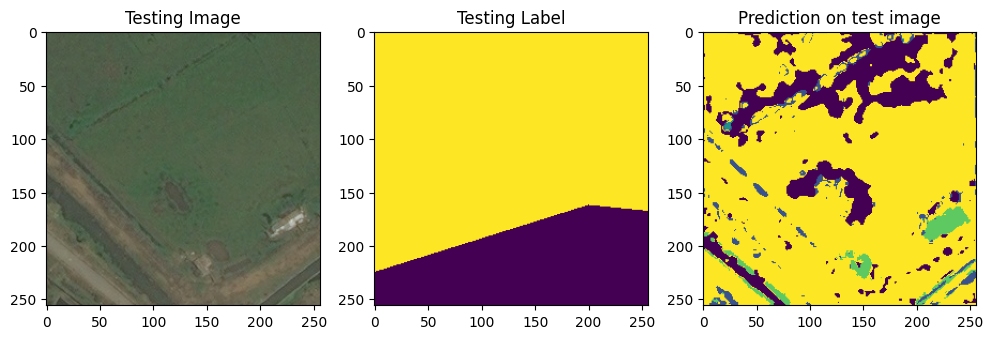

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


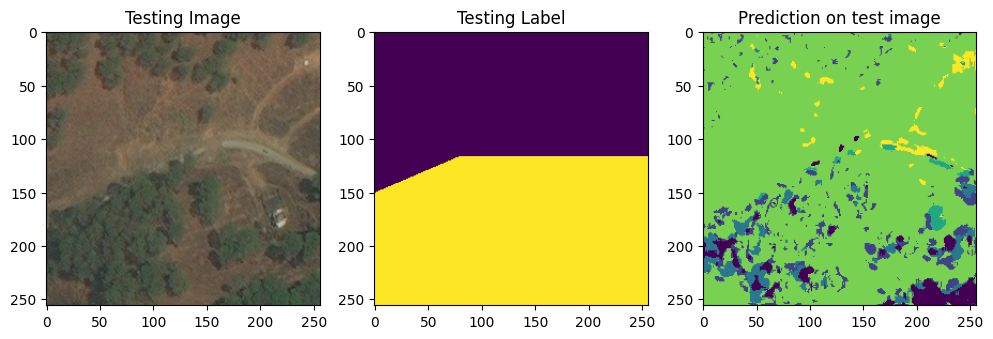

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


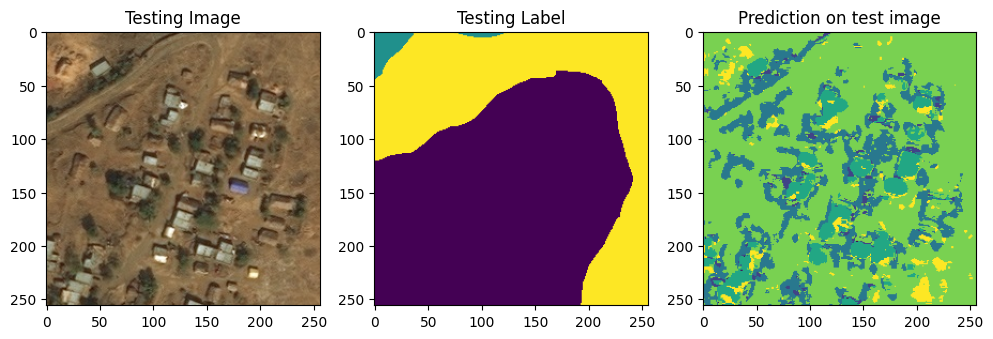

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


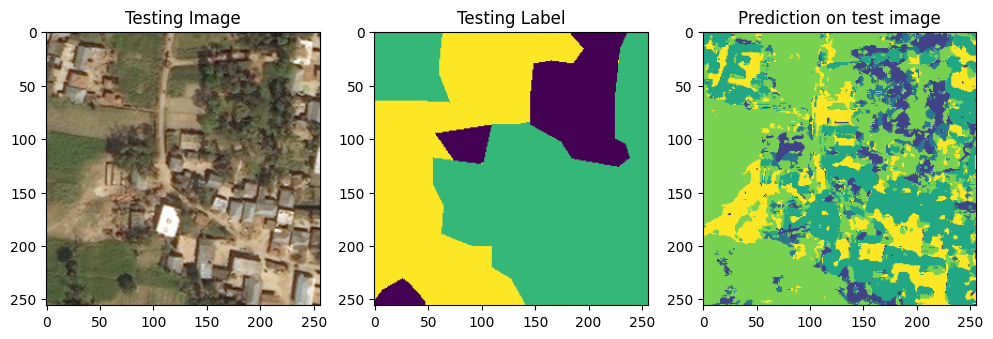

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


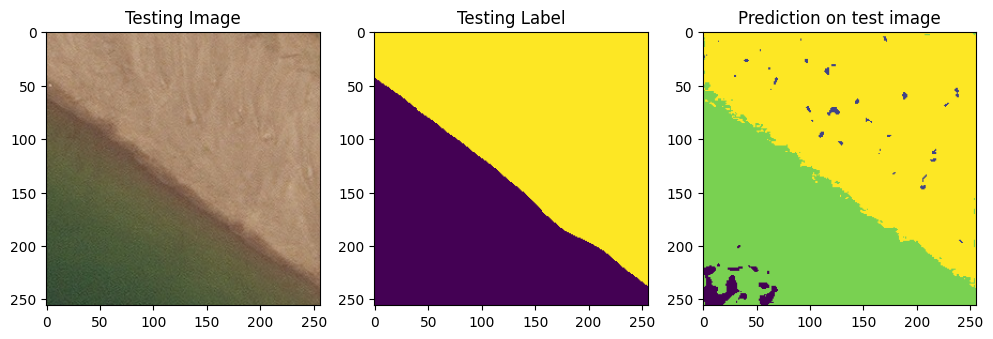

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


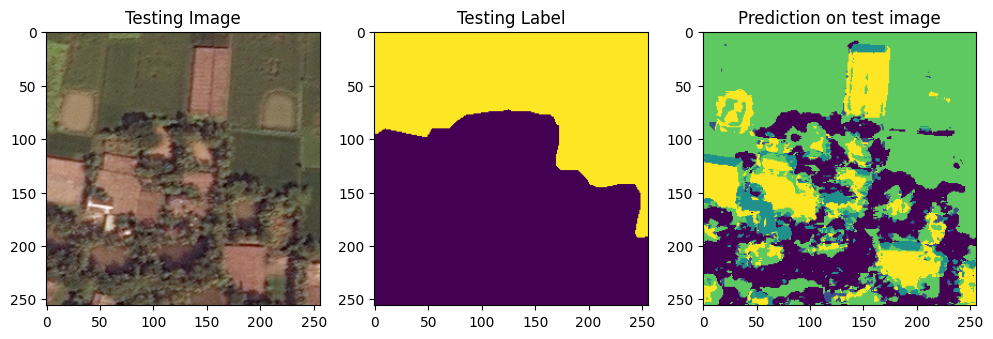

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


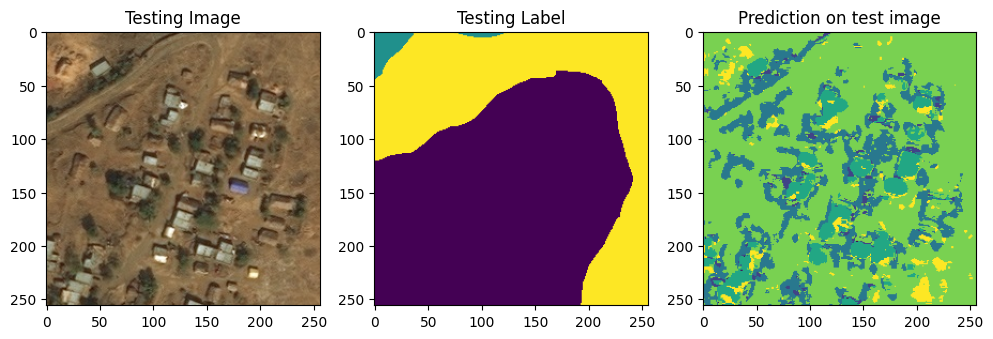

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


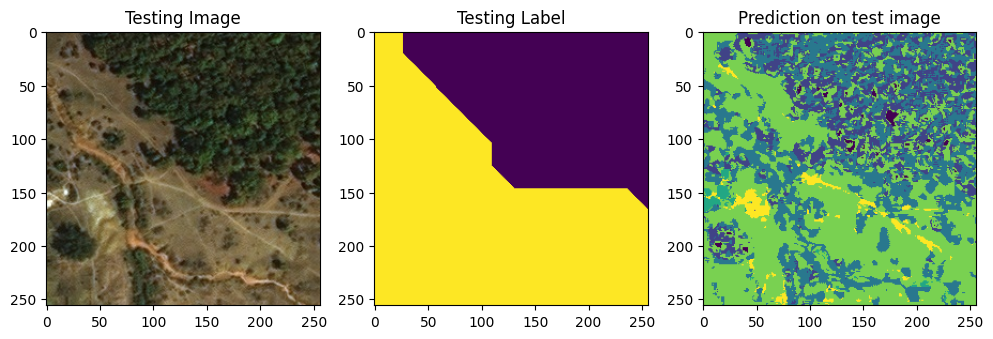

In [23]:
visualize_predictions(model_UNet)

5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step
Mean IoU : 0.24888329


<ipython-input-18-64668a2d8d8b>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'weight': 'bold'})


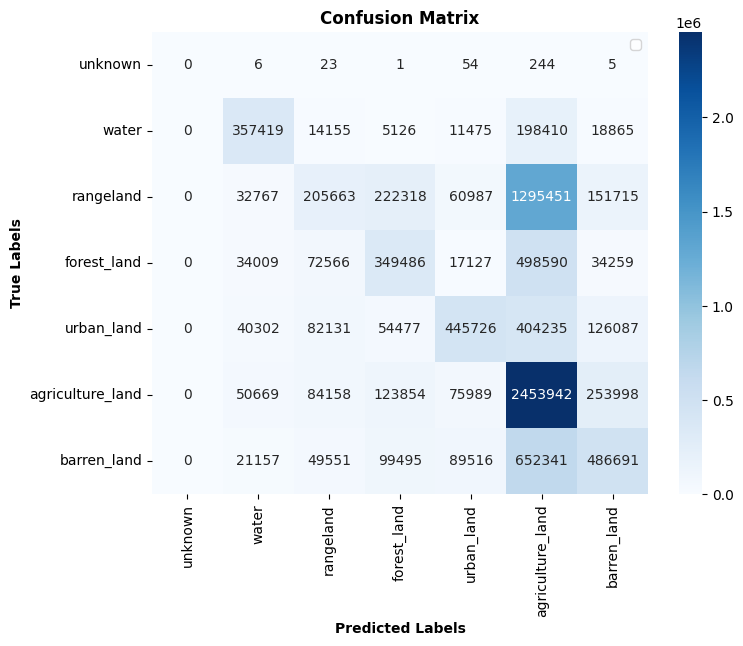

IoU for Class 'unknown' : 0.0000
IoU for Class 'water' : 0.4557
IoU for Class 'rangeland' : 0.0905
IoU for Class 'forest_land' : 0.2312
IoU for Class 'urban_land' : 0.3165
IoU for Class 'agriculture_land' : 0.4028
IoU for Class 'barren_land' : 0.2453


In [24]:
evaluate_model_performance(model_UNet)

Enhanced U-Net

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Activation, Add, concatenate, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = SpatialDropout2D(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(num_filters, 1, padding="same")(input)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x)

    return x

def encoder_block(input, num_filters, dropout_rate=0.3):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    p = Dropout(dropout_rate)(p)
    return x, p

def attention_block(x, g, num_filters):
    theta_x = Conv2D(num_filters, 1, padding="same")(x)
    phi_g = Conv2D(num_filters, 1, padding="same")(g)
    attn_map = Activation('relu')(Add()([theta_x, phi_g]))
    attn_map = Conv2D(1, 1, activation='sigmoid', padding="same")(attn_map)
    return x * attn_map

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 3, strides=(2, 2), padding="same")(input)
    skip_features = attention_block(skip_features, x, num_filters)

    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def bottleneck(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = bottleneck(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net-Enhanced")
    return model

optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)

model_UNet = build_unet(input_shape, n_classes=7)
model_UNet.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy'])
model_UNet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "U-Net-Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ leaky_re_lu[0][0]      │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_2[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ max_pooling2d[0][0]    │
├──────────────────────

 Total params: 42,391,115 (161.71 MB)

 Trainable params: 42,371,659 (161.64 MB)

 Non-trainable params: 19,456 (76.00 KB)

In [ ]:
history_UNet = model_UNet.fit(X_train, y_train_cat,
                              batch_size = 4,
                              verbose=1,
                              epochs=100,
                              validation_data=(X_test, y_test_cat),
                              shuffle=True)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 175s 581ms/step - accuracy: 0.3392 - loss: 1.0955 - val_accuracy: 0.3316 - val_loss: 1.0707
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 134s 563ms/step - accuracy: 0.3786 - loss: 0.9636 - val_accuracy: 0.3316 - val_loss: 1.0589
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 525ms/step - accuracy: 0.3841 - loss: 0.9334 - val_accuracy: 0.3599 - val_loss: 1.0720
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 87s 560ms/step - accuracy: 0.3990 - loss: 0.9317 - val_accuracy: 0.2737 - val_loss: 7.8404
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 559ms/step - accuracy: 0.4119 - loss: 0.9083 - val_accuracy: 0.2863 - val_loss: 1.4678
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 525ms/step - accuracy: 0.4113 - loss: 0.9057 - val_accuracy: 0.3199 - val_loss: 1.1793
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 524ms/step - accuracy: 0.4061 - loss: 0.8994 - val_accuracy: 0.3980 - val_loss: 0.9031
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 87s 558ms/step - accuracy: 0.4297

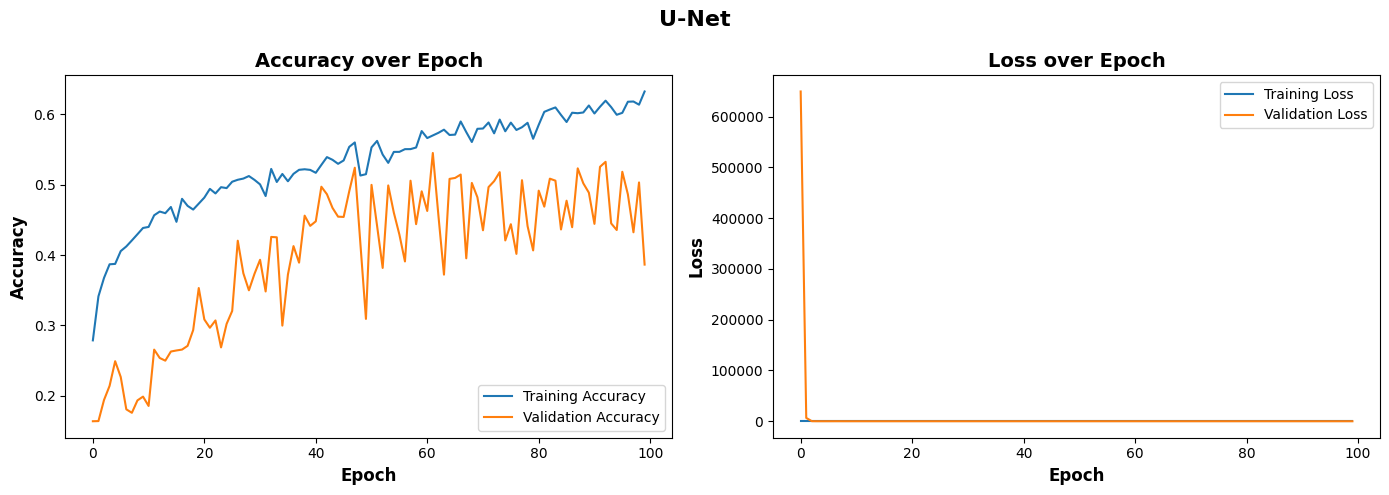

In [ ]:
plot_training_history(history_UNet, 'U-Net')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


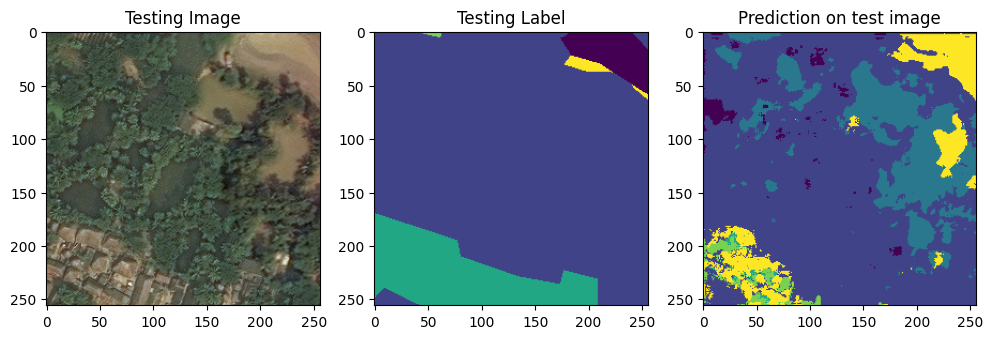

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


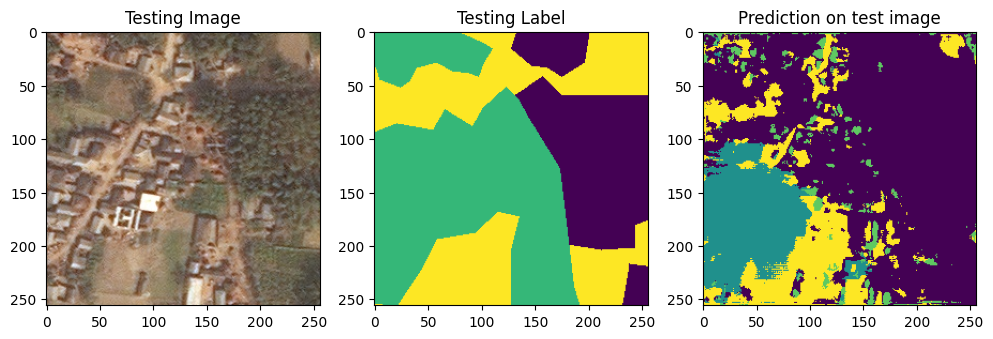

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


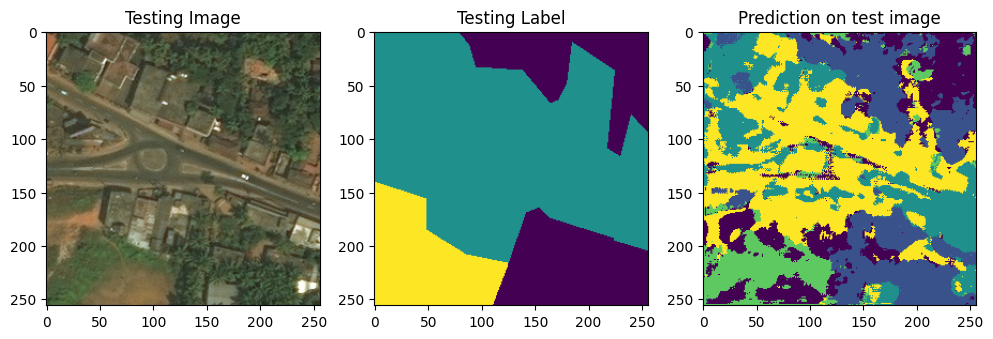

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


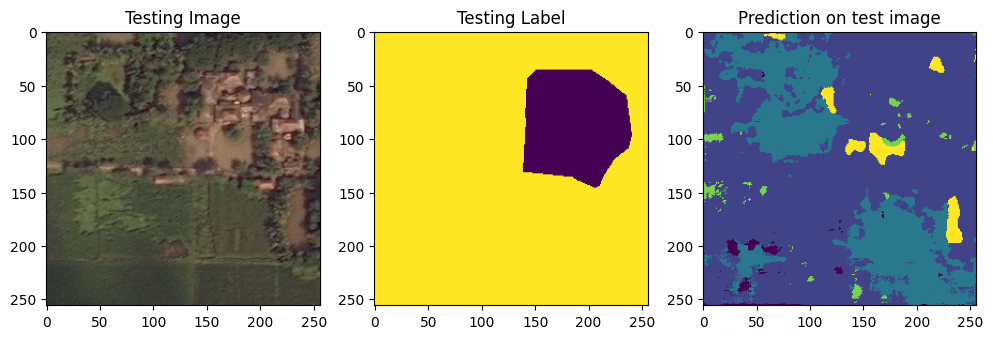

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


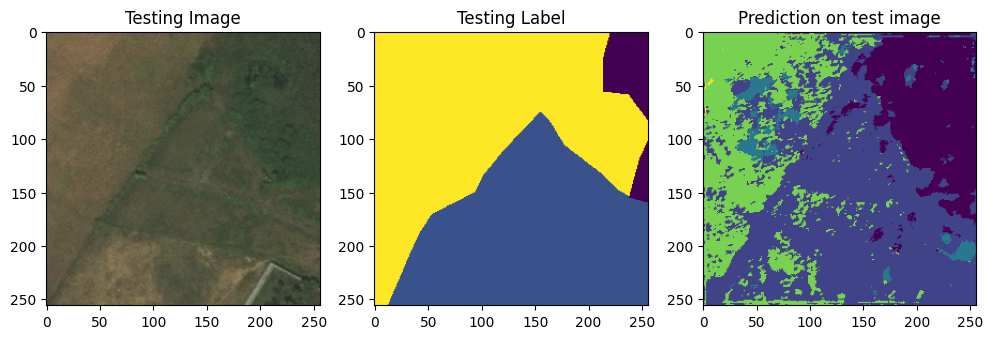

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


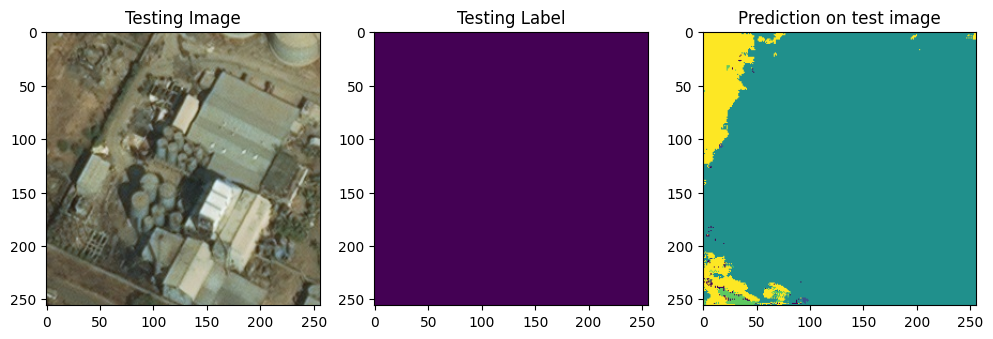

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


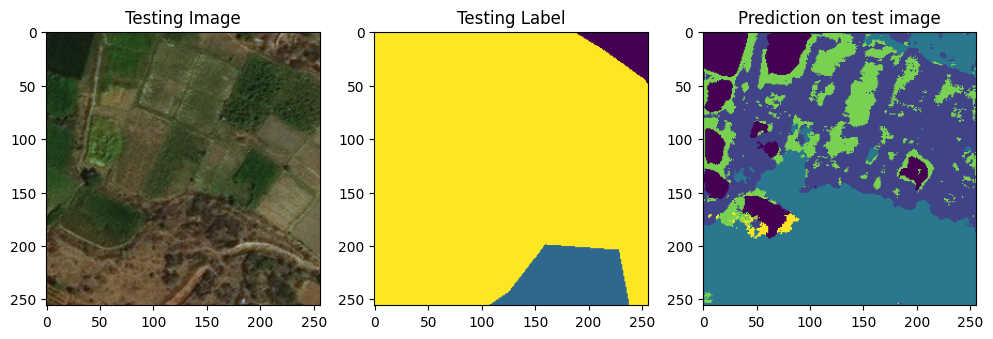

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


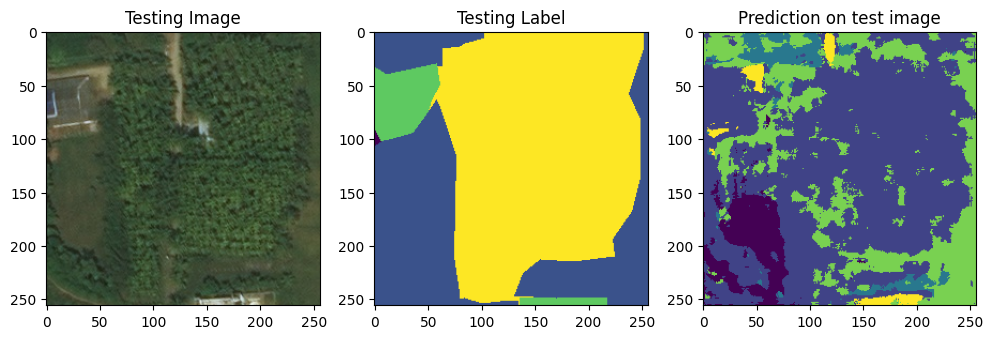

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


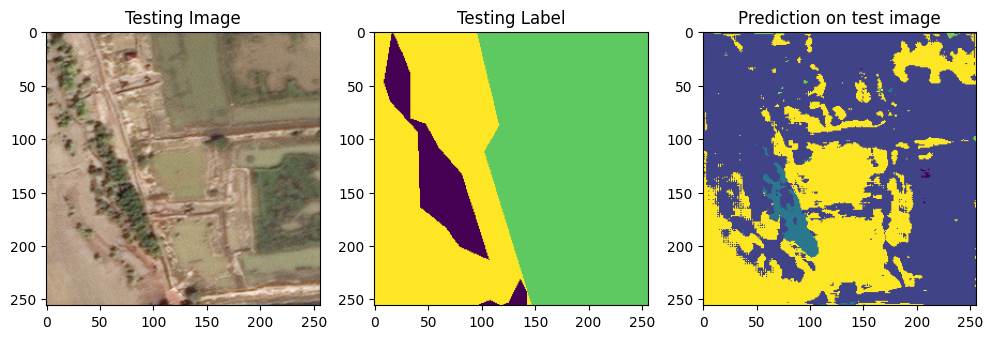

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


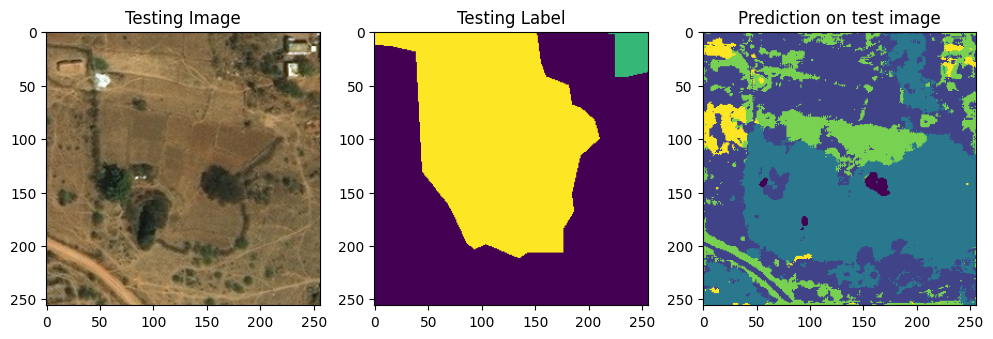

In [ ]:
visualize_predictions(model_UNet)

2/2 ━━━━━━━━━━━━━━━━━━━━ 106s 48s/step
Mean IoU : 0.28458688


<ipython-input-19-64668a2d8d8b>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'weight': 'bold'})


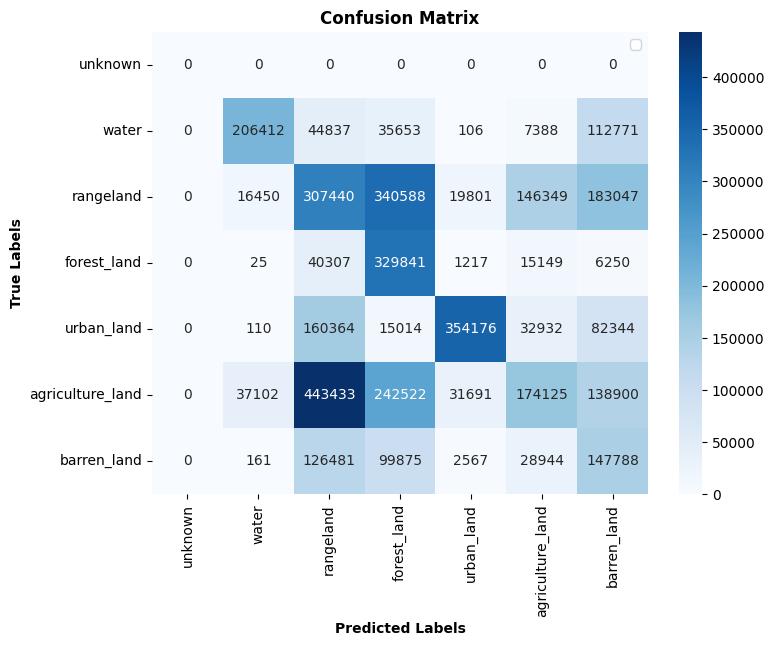

IoU for Class 'unknown' : 0.0000
IoU for Class 'water' : 0.4477
IoU for Class 'rangeland' : 0.1681
IoU for Class 'forest_land' : 0.2928
IoU for Class 'urban_land' : 0.5057
IoU for Class 'agriculture_land' : 0.1341
IoU for Class 'barren_land' : 0.1591


In [ ]:
evaluate_model_performance(model_UNet)